In [ ]:
!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip quora.zip
!pip install -q --upgrade nltk gensim bokeh pandas

import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Словные эмбеддинги

Все видели такие картинки (я надеюсь):
![embeddings relations](https://www.tensorflow.org/images/linear-relationships.png)
*From [Vector Representations of Words, Tensorflow tutorial](https://www.tensorflow.org/tutorials/representation/word2vec)*

Сегодня будем заниматься такими моделями.

Начнём утро с визуализаций. Идём на сайт [http://rusvectores.org/ru/](http://rusvectores.org/ru/) и смотрим, что умеют обученные модели для русского.

Обратите внимание на разделы *Похожие слова* и *Калькулятор*, а также на набор моделей, которые в них можно выбирать.

## Тренируем простую модель

Просто так смотреть на чужие модели, конечно, неприкольно - поэтому будем постепенно приближаться к решению конкретной задачи: [Quora Question Pairs at kaggle](https://www.kaggle.com/c/quora-question-pairs):

In [1]:
import pandas as pd

quora_data = pd.read_csv('train.csv')

quora_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Поучим на этих текстах Word2vec из gensim. 

Для начала объединим все тексты.

In [2]:
import numpy as np

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())
texts[:10]

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?']

Для токенизации проще всего воспользоваться `nltk` (он быстрее `spacy`, но может быть хуже в отдельных случаях).

In [3]:
from nltk.tokenize import word_tokenize

word_tokenize(texts[0])

['What',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

**Задание** Приведите все тексты к нижнему регистру и токенизируйте их.

In [4]:
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

assert all(isinstance(row, (list, tuple)) for row in tokenized_texts), \
    "please convert each line into a list of tokens"
assert all(all(isinstance(tok, str) for tok in row) for row in tokenized_texts), \
    "please convert each line into a list of tokens"

is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(not is_latin(token) or token.islower() for tokens in tokenized_texts for token in tokens),\
    "please lowercase each line"

In [5]:
print([' '.join(row) for row in tokenized_texts[:2]])

['what is the step by step guide to invest in share market in india ?', 'what is the story of kohinoor ( koh-i-noor ) diamond ?']


Потренируем небольшую модель на полученных текстах:

In [6]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized_texts, 
                 size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

## Изучаем полученную модель

Ура, теперь можно делать то же, что было на `rusvectores`.

Получить вектор для слова:

In [7]:
model.get_vector('anything')

array([ 2.199593  ,  3.235803  , -0.23519777, -2.2455592 ,  0.0342233 ,
        0.6809146 , -1.6098799 , -0.7663983 ,  0.9463719 ,  3.704383  ,
       -1.1812023 , -1.3031893 ,  1.3230419 , -5.778375  ,  0.8843493 ,
       -0.4652613 , -2.446592  ,  0.55939907, -3.7332988 , -2.3577976 ,
       -1.3424994 ,  0.9876267 , -0.7965509 , -0.98043513,  0.90772384,
        2.4068813 , -2.006487  , -1.1047843 , -2.227893  ,  0.40094423,
       -1.4013709 ,  0.6818166 ], dtype=float32)

Найти наиболее близкие слова:

In [8]:
model.most_similar('bread')

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('rice', 0.9668948650360107),
 ('cheese', 0.9239578247070312),
 ('honey', 0.9208371639251709),
 ('potato', 0.9200029373168945),
 ('wine', 0.9197816848754883),
 ('fruit', 0.9106698036193848),
 ('beans', 0.9083821177482605),
 ('pasta', 0.9078223705291748),
 ('butter', 0.9069316387176514),
 ('vodka', 0.9045554995536804)]

Или даже так:

In [9]:
model.most_similar(positive=['coder', 'money'], negative=['brain'])

[('mnc', 0.6460824012756348),
 ('cents', 0.6455078125),
 ('poker', 0.6411752700805664),
 ('freelancer', 0.6389911770820618),
 ('photographer', 0.6366746425628662),
 ('software', 0.6344296932220459),
 ('soccer', 0.6244983673095703),
 ('millionaire', 0.6182782053947449),
 ('classpass', 0.6103410720825195),
 ('dubai', 0.6096907258033752)]

И так, конечно:

In [10]:
model.most_similar([model.get_vector('politician') - model.get_vector('power') + model.get_vector('honesty')])

[('romantic', 0.7300705909729004),
 ('actress', 0.6730947494506836),
 ('punjabi', 0.6472324132919312),
 ('erotic', 0.6341289281845093),
 ('prettiest', 0.6319241523742676),
 ('sexy', 0.6294460296630859),
 ('handsome', 0.6283881664276123),
 ('singer', 0.6278672218322754),
 ('actor', 0.6196695566177368),
 ('bengali', 0.6154521107673645)]

**Задание** Поищите аналогии самостоятельно. 

## Визуализируем модель

Посмотрим на проекции первых тысячи самых частотных слов.

In [11]:
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:1000]

print(words[::100])

['?', 'money', 'study', 's', '6', 'physics', 'says', 'view', 'users', 'pressure']


**Задание** Постройте матрицу из эмбеддингов этих слов:

In [12]:
word_vectors = model.vectors[[model.vocab[word].index for word in words]]

assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), model.vectors.shape[1])
assert np.isfinite(word_vectors).all()

In [13]:
word_vectors.shape

(1000, 32)

### PCA

Простейший линейный метод сокращения размерностей - __P__rincipial __C__omponent __A__nalysis.

PCA ищет оси, при проекции на которые данные будут иметь наибольший разброс.

![pca](https://i.stack.imgur.com/Q7HIP.gif)
*From [https://stats.stackexchange.com/a/140579](https://stats.stackexchange.com/a/140579)*

В результате, можно взять проекции на несколько первых компонент - и сохранить как можно больше информации, сократив размерность.

Красивые визуализации можно найти [здесь](http://setosa.io/ev/principal-component-analysis/).

**Задание** Воспользуйтесь PCA из sklearn, а потом центрируйте и нормируйте результат.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def get_pca_projection(word_vectors):
    pca = PCA(n_components=2)
    word_vectors = pca.fit_transform(word_vectors)
    sc = StandardScaler()
    word_vectors = sc.fit_transform(word_vectors)
    return word_vectors

In [16]:
word_vectors_pca = get_pca_projection(word_vectors)

assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1 - word_vectors_pca.std(0))) < 1e-5, "points must have unit variance"

Визуализируем то, что получилось:

In [17]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig

In [18]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Loading BokehJS ...

Figure(id='1003', ...)

### TSNE

Более интересный и сложный (нелинейный) метод для визуализации высокоразмерных пространств - TSNE. Подробно посмотреть на него можно [здесь](https://distill.pub/2016/misread-tsne/) (ещё более красивые картинки!).

**Задание** Как и с PCA - воспользуйтесь TSNE из sklearn и нормируйте + центрируйте результат.

In [19]:
from sklearn.manifold import TSNE

def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2)
    word_vectors = tsne.fit_transform(word_vectors)
    sc = StandardScaler()
    word_vectors = sc.fit_transform(word_vectors)
    return word_vectors

In [20]:
word_tsne = get_tsne_projection(word_vectors)
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

Loading BokehJS ...

Figure(id='1113', ...)

## Эмбеддим фразы

Сейчас для тестов будет полезно пользоваться фиксированными эмбеддингами. Загрузим уже обученную модель.  
(посмотреть, какие вообще модели и корпуса доступны, можно вызовом `api.info()`)

In [21]:
import gensim.downloader as api

model = api.load('glove-twitter-100')

Простой и дешевый способ посчитать эмбеддинг фразы, когда есть эмбеддинги слов - усреднить.

Вот этим и займемся: токенизируйте и приведите к нижнему регистру фразу, усредните эмбеддинги тех слов, для которых они подсчитаны.

**Задание** Напишите функцию для подсчета эмбеддинга фразы.

In [22]:
def get_phrase_embedding(model, phrase):    
    vector = np.zeros([model.vector_size], dtype='float32')
    tokens = word_tokenize(phrase.lower())
    k = 0
    for token in tokens:
        if token in model.vocab:
            k += 1
            vector += model.get_vector(token)
    
    if k != 0:
        return vector/k
    return vector

In [23]:
vector = get_phrase_embedding(model, "I'm very sure. This never happened to me before...")
assert np.allclose(vector[::10],
                   np.array([ 0.30757686, -0.05861897,  0.143751  , -0.11104885, -0.96929336,
                             -0.21928601,  0.21652265,  0.14978765,  1.4842536 ,  0.017826  ],
                              dtype=np.float32))

Подсчитаем вектора всех фраз.

In [24]:
text_vectors = np.array([get_phrase_embedding(model, phrase) for phrase in texts])

И научимся искать ближайшие!

**Задание** По строке найти k ближайших к ней вопросов.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest(model, text_vectors, texts, query, k=10):
    emb = get_phrase_embedding(model, query)
    sm = cosine_similarity(text_vectors, emb[np.newaxis, :]).ravel()
    return [texts[i] for i in np.argsort(sm)[-k:]][::-1]

In [26]:
results = find_nearest(model, text_vectors, texts, query="How do i enter the matrix?", k=10)

print('\n'.join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[1] == 'How do I get to the dark web?'
assert results[4] == 'What can I do to save the world?'

How do I download the Mengto's Design-Code book?
How do I get to the dark web?
What should I do to enter hollywood?
How do I use the Greenify app?
What can I do to save the world?
How do I win this?
How do I think out of the box? How do I learn to think out of the box?
How do I find the 5th dimension?
How do I use the pad in MMA?
How do I estimate the competition?


In [27]:
find_nearest(model, text_vectors, texts, query="How does Trump?", k=10)

['What does Donald Trump think about Israel?',
 'What books does Donald Trump like?',
 'What does Donald Trump think of India?',
 'What does India think of Donald Trump?',
 'What does Donald Trump think of China?',
 'What does Donald Trump think about Pakistan?',
 'What companies does Donald Trump own?',
 'What does Dushka Zapata think about Donald Trump?',
 'Does Donald Trump have dementia/alzheimers?',
 'How does it feel to date Ivanka Trump?']

In [28]:
find_nearest(model, text_vectors, texts, query="Why don't i ask a question myself?", k=10)

["Why do you always answer a question with a question? I don't, or do I?",
 'Why do I ask this question?',
 'How do I ask a question?',
 'How do I ask a question on this?',
 "Why do I have to ask a girl out? Why can't she ask me?",
 'How do I downvote a question?',
 'How do I ask someone on a date?',
 'Why do I question myself about this?',
 "How do I ask a girl I don't know to fuck?",
 'How do you ask a question?']

## Начинаем классификацию

### Bag-of-words

**Задание** Соберем для начала токенизированные вопросы.

In [29]:
tokenized_question1 = np.array([get_phrase_embedding(model, phrase) for phrase in quora_data.question1])
tokenized_question2 = np.array([get_phrase_embedding(model, phrase) for phrase in quora_data.question2])

In [30]:
tokenized_question1.shape

(404290, 100)

**Задание** Посчитайте косинусную близость между вопросами.

Проще всего реализовать функцию ее вычисления руками:
$$\text{cosine_similarity}(x, y) = \frac{x^{T} y}{||x||\cdot ||y||}$$

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = np.array([
    cosine_similarity(
        tokenized_question1[i][np.newaxis, :], 
        tokenized_question2[i][np.newaxis, :]
    ) 
    for i in range(len(quora_data))
])

In [32]:
cosine_similarities = cosine_similarities.ravel()
cosine_similarities.shape

(404290,)

Подберём порог близости, при котором будем считать тексты одинаковыми.

**Задание** Реализуйте функцию `accuracy`, вычисляющую точность классификации при заданном пороге.

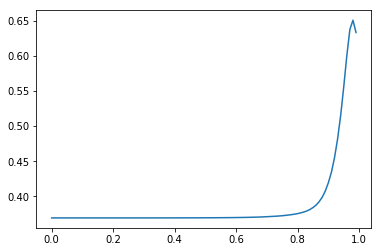

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline
def accuracy(cosine_similarities, threshold):
    return accuracy_score(quora_data.is_duplicate, (cosine_similarities > threshold).astype("int"))

thresholds = np.linspace(0, 1, 100, endpoint=False)
plt.plot(thresholds, [accuracy(cosine_similarities, th) for th in thresholds])

И запустим оптимизацию:

In [34]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(lambda x: -accuracy(cosine_similarities, x), bounds=(0.5, 0.99), method='bounded')
best_threshold = res.x
print('Threshold = {:.5f}, Accuracy = {:.2%}'.format(best_threshold, accuracy(cosine_similarities, best_threshold)))

Threshold = 0.97940, Accuracy = 65.10%


### Tf-idf weights

Вместо того, чтобы тупо усреднять вектора, можно усреднять их с учетом весов - поможет в этом уже знакомые tf-idf.

**Задание** Посчитайте взвешенные вектора вопросов. Используйте `TfidfVectorizer`

`TfidfVectorizer` возвращает матрицу `(samples_count, words_count)`. А наши эмбеддинги имеют размерность `(words_count, embedding_dim)`. Значит, их можно просто перемножить. Тогда каждая фраза - последовательность слов $w_1, \ldots, w_k$ - преобразуется в вектор $\sum_i \text{idf}(w_i) \cdot \text{embedding}(w_i)$. Этот вектор, вероятно, стоит нормировать на число слов $k$.

**Задание** Кроме tf-idf можно добавить фильтрацию стоп-слов и пунктуации.  
Стоп-слова можно взять из `nltk`:
```python
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
```

In [35]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation

stop_words = stopwords.words('english')

In [48]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words = stop_words, norm = 'l1')

vectorizer.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [49]:
tfidf1 = vectorizer.transform(quora_data.question1)
tfidf2 = vectorizer.transform(quora_data.question2)

In [50]:
tfidf1.shape, tfidf2.shape

((404290, 86010), (404290, 86010))

In [39]:
embeddings = np.array([
    list(model.get_vector(k)) 
    if k in model.vocab 
    else list(np.zeros([model.vector_size], dtype='float32')) 
    for k in vectorizer.vocabulary_.keys()])

In [40]:
embeddings.shape

(86010, 100)

In [51]:
tfidf_question1 = tfidf1.dot(embeddings)
tfidf_question2 = tfidf2.dot(embeddings)

In [52]:
tfidf_question1.shape

(404290, 100)

Посмотрим, что получается после фильтрации и векторизации:

In [ ]:
for col in tfidf1[0].tocoo().col:
    print(model.index2word[col], end=' ')

print('\n' + ' '.join(tokenized_question1[0]))

**Задание** Посчитайте качество с новыми векторами.

In [53]:
cosine_similarities = np.array([
    cosine_similarity(
        tfidf_question1[i][np.newaxis, :], 
        tfidf_question2[i][np.newaxis, :]
    ) 
    for i in range(len(quora_data))
]).ravel()

res = minimize_scalar(lambda x: -accuracy(cosine_similarities, x), bounds=(0.8, 0.99), method='bounded')
best_threshold = res.x
print('Threshold = {:.5f}, Accuracy = {:.2%}'.format(best_threshold, accuracy(cosine_similarities, best_threshold)))

Threshold = 0.84312, Accuracy = 66.67%


## Посмотрим внутрь обучения словных эмбеддингов

Ключевая идея - слово можно определить по контексту, в котором оно встречается:
![contexts](https://image.ibb.co/mnQ2uz/2018_09_17_21_07_08.png)
*From [cs224n, Lecture 2](http://web.stanford.edu/class/cs224n/lectures/lecture2.pdf)*

Смотреть, как всё учится, будем здесь: [https://ronxin.github.io/wevi/](https://ronxin.github.io/wevi/).

## Запилим пословный машинный перевод!

In [ ]:
!wget -O ukr_rus.train.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vAK0SWXUqei4zTimMvIhH3ufGPsbnC_O"
!wget -O ukr_rus.test.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1W9R2F8OeKHXruo2sicZ6FgBJUTJc8Us_"
!wget -O fairy_tale.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1sq8zSroFeg_afw-60OmY8RATdu_T1tej"

!unzip cc.ru.300.vec.zip
!unzip cc.uk.300.vec.zip

Напишем простенькую реализацию модели машинного перевода.

Идея основана на статье [Word Translation Without Parallel Data](https://arxiv.org/pdf/1710.04087.pdf). У авторов в репозитории еще много интересного: [https://github.com/facebookresearch/MUSE](https://github.com/facebookresearch/MUSE).

А мы будем переводить с украинского на русский.

![](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/blue_cat_blue_whale.png)   
*синій кіт* vs. *синій кит*

In [ ]:
from gensim.models import KeyedVectors

ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")
uk_emb = KeyedVectors.load_word2vec_format("cc.uk.300.vec")

Посмотрим на пару серпень-август (являющихся переводом)

In [ ]:
ru_emb.most_similar([ru_emb["август"]])

In [ ]:
uk_emb.most_similar([uk_emb["серпень"]])

In [ ]:
ru_emb.most_similar([uk_emb["серпень"]])

In [ ]:
def load_word_pairs(filename):
    uk_ru_pairs = []
    uk_vectors = []
    ru_vectors = []
    with open(filename, "r", encoding='utf8') as inpf:
        for line in inpf:
            uk, ru = line.rstrip().split("\t")
            if uk not in uk_emb or ru not in ru_emb:
                continue
            uk_ru_pairs.append((uk, ru))
            uk_vectors.append(uk_emb[uk])
            ru_vectors.append(ru_emb[ru])
    return uk_ru_pairs, np.array(uk_vectors), np.array(ru_vectors)


uk_ru_train, X_train, Y_train = load_word_pairs("ukr_rus.train.txt")
uk_ru_test, X_test, Y_test = load_word_pairs("ukr_rus.test.txt")

### Учим маппинг из одного пространства эмбеддингов в другое

У нас есть пары слов, соответствующих друг другу, и их эмбеддинги. Найдем преобразование из одного пространства в другое, чтобы приблизить известные нам слова:

$$W^*= \arg\min_W ||WX - Y||_F, \text{где} ||*||_F - \text{норма Фробениуса}$$

Эта функция очень похожа на линейную регрессию (без биаса).

**Задание** Реализуйте её - воспользуйтесь `LinearRegression` из sklearn с `fit_intercept=False`:

In [ ]:
mapping = ...

Проверим, куда перейдет `серпень`:

In [ ]:
august = mapping.predict(uk_emb["серпень"].reshape(1, -1))
ru_emb.most_similar(august)

Должно получиться, что в топе содержатся разные месяцы, но август не первый.

Будем мерять percision top-k с k = 1, 5, 10.

**Задание** Реализуйте следующую функцию:

In [ ]:
def precision(pairs, mapped_vectors, topn=1):
    """
    :args:
        pairs = list of right word pairs [(uk_word_0, ru_word_0), ...]
        mapped_vectors = list of embeddings after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    assert len(pairs) == len(ru_vectors)
    num_matches = 0
    for i, (_, ru) in enumerate(pairs):
        <write code here>
    precision_val = num_matches / len(pairs)
    return precision_val

In [ ]:
assert precision([("серпень", "август")], august, topn=5) == 0.0
assert precision([("серпень", "август")], august, topn=9) == 1.0
assert precision([("серпень", "август")], august, topn=10) == 1.0

In [ ]:
assert precision(uk_ru_test, X_test) == 0.0
assert precision(uk_ru_test, Y_test) == 1.0

In [ ]:
precision_top1 = precision(uk_ru_test, mapping.predict(X_test), 1)
precision_top5 = precision(uk_ru_test, mapping.predict(X_test), 5)

assert precision_top1 >= 0.635
assert precision_top5 >= 0.813

### Улучшаем маппинг

Можно показать, что маппинг лучше строить ортогональным:
$$W^*= \arg\min_W ||WX - Y||_F \text{, где: } W^TW = I$$

Искать его можно через SVD:
$$X^TY=U\Sigma V^T\text{, singular value decompostion}$$

$$W^*=UV^T$$

**Задание** Реализуйте эту функцию.

In [ ]:
def learn_transform(X_train, Y_train):
    """ 
    :returns: W* : float matrix[emb_dim x emb_dim] as defined in formulae above
    """
    <write code there>

In [ ]:
W = learn_transform(X_train, Y_train)

In [ ]:
ru_emb.most_similar([np.matmul(uk_emb["серпень"], W)])

In [ ]:
assert precision(uk_ru_test, np.matmul(X_test, W)) >= 0.653
assert precision(uk_ru_test, np.matmul(X_test, W), 5) >= 0.824

### Пишем переводчик

Реализуем простой пословный переводчик - для каждого слова будем искать его ближайшего соседа в общем пространстве эмбеддингов. Если слова нет в эмбеддингах - просто копируем его.

In [ ]:
with open("fairy_tale.txt", "r") as in f:
    uk_sentences = [line.rstrip().lower() for line in in f]

In [ ]:
def translate(sentence):
    """
    :args:
        sentence - sentence in Ukrainian (str)
    :returns:
        translation - sentence in Russian (str)

    * find ukrainian embedding for each word in sentence
    * transform ukrainian embedding vector
    * find nearest russian word and replace
    """
    <implement it!>

In [ ]:
assert translate(".") == "."
assert translate("1 , 3") == "1 , 3"
assert translate("кіт зловив мишу") == "кот поймал мышку"

In [ ]:
for sentence in uk_sentences:
    print("src: {}\ndst: {}\n".format(sentence, translate(sentence)))

# Сдача задания

[Форма для сдачи](https://goo.gl/forms/GGjrH7axdGJr6yTp2)  
[Опрос](https://goo.gl/forms/3QRwLTmLgBzl5VVm2)

# Дополнительные материалы

## Почитать
### База:  
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[Deep Learning, NLP, and Representations, Christopher Olah](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)  

### Как кластеризовать смыслы многозначных слов:  
[Making Sense of Word Embeddings (2016), Pelevina et al](http://anthology.aclweb.org/W16-1620)    

### Как оценивать эмбеддинги
[Evaluation methods for unsupervised word embeddings (2015), T. Schnabel](http://www.aclweb.org/anthology/D15-1036)  
[Intrinsic Evaluation of Word Vectors Fails to Predict Extrinsic Performance (2016), B. Chiu](https://www.aclweb.org/anthology/W/W16/W16-2501.pdf)  
[Problems With Evaluation of Word Embeddings Using Word Similarity Tasks (2016), M. Faruqui](https://arxiv.org/pdf/1605.02276.pdf)  
[Improving Reliability of Word Similarity Evaluation by Redesigning Annotation Task and Performance Measure (2016), Oded Avraham, Yoav Goldberg](https://arxiv.org/pdf/1611.03641.pdf)  
[Evaluating Word Embeddings Using a Representative Suite of Practical Tasks (2016), N. Nayak](https://cs.stanford.edu/~angeli/papers/2016-acl-veceval.pdf)  


## Посмотреть
[Word Vector Representations: word2vec, Lecture 2, cs224n](https://www.youtube.com/watch?v=ERibwqs9p38)